In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from typing import Any, List
import math
import mtm
from mtm import matchTemplates
from mtm.detection import plotDetections
from skimage.data import coins

In [33]:
image = cv2.imread('dane/test.png')
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h_image,s_image,v_image = cv2.split(image_hsv)
template = cv2.imread('dane/white_long.png')
template_hsv = cv2.cvtColor(template, cv2.COLOR_BGR2HSV)
h_template,s_template,v_template = cv2.split(template_hsv)

In [34]:
image = cv2.imread('dane/calib.png')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
template = cv2.imread('dane/white_long.png')
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

In [35]:
# Function to rotate an image
def rotate_image_with_padding(image, angle):
    """
    Rotate the given image by the specified angle, ensuring no clipping occurs.

    Parameters:
        image (ndarray): Input image.
        angle (float): Angle by which the image is rotated.

    Returns:
        rotated_image (ndarray): Rotated image with no clipping.
    """
    # Get image dimensions
    height, width = image.shape
    diagonal = int(np.sqrt(height**2 + width**2))  # Compute diagonal length
    new_size = diagonal  # New canvas size

    # Add padding to fit the diagonal
    padded_image = cv2.copyMakeBorder(image, 
                                      (new_size - height) // 2, 
                                      (new_size - height) // 2, 
                                      (new_size - width) // 2, 
                                      (new_size - width) // 2, 
                                      cv2.BORDER_CONSTANT, 
                                      value=95) #Do zmiany wartości w zależności od tła!!

    # Perform the rotation
    center = (new_size // 2, new_size // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)
    rotated_image = cv2.warpAffine(padded_image, rotation_matrix, (new_size, new_size), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=95)#Tutaj też do zmiany border value!!

    return rotated_image

In [36]:
def get_bounding_box(image):
    """
    Detect the bounding box of the largest object in the image.
    """
    # Threshold the image to create a binary mask
    _, binary = cv2.threshold(image,90, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #cv2.drawContours(image, contours, -1, (0, 255, 0), 3) 
  
    #cv2.imshow('Contours', image) 
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows() 
    # Filter and select the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    if largest_contour is None:
        return None  # Return None if no contour is detected

    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)

    return x, y, w, h

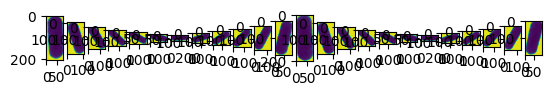

In [37]:
# Rotate the s_template image at specific angles
angles = range(15, 360, 15)  # Angles: 15°, 30°, 45°, ..., 345°
listTemplates = [h_template]
listLabels    = ["Temp0"]

f, axarr = plt.subplots(1,24)
axarr[0].imshow(h_template)

for i,angle in enumerate(angles):
    rotated = rotate_image_with_padding(h_template, angle)

    # Detect the bounding box for the pill
    x, y, w, h = get_bounding_box(rotated)

    # Crop the image using the bounding box
    cropped = rotated[y:y+h, x:x+w]
    listTemplates.append(cropped)
    listLabels.append(str(angle))
    axarr[i+1].imshow(cropped)

In [40]:
listDetections = matchTemplates(h_image, 
                                listTemplates,
                                listLabels,
                                scoreThreshold=0.75, 
                                maxOverlap=0.1,
                               downscalingFactor=4)

print("Found {} hits".format( len(listDetections) ) )
listDetections

Found 4 hits


[(BoundingBox, score:0.95, xywh:(np.int64(1504), np.int64(992), 96, 196), index:23, 345),
 (BoundingBox, score:0.92, xywh:(np.int64(1808), np.int64(768), 192, 108), index:7, 105),
 (BoundingBox, score:0.88, xywh:(np.int64(1408), np.int64(628), 180, 140), index:8, 120),
 (BoundingBox, score:0.83, xywh:(np.int64(1100), np.int64(800), 200, 76), index:18, 270)]

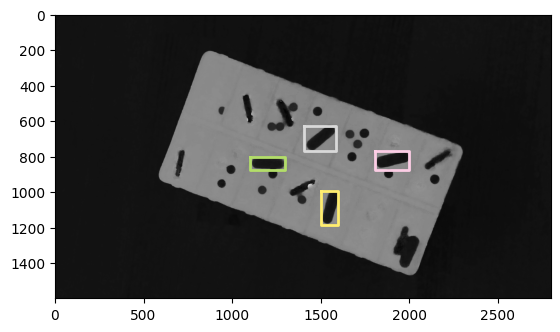

In [41]:
plotDetections(h_image, listDetections)

## Detect all elongated pills